In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import tensorflow_datasets as tfds

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_dataset = pd.read_csv('/Users/ddroder/work/code/hw/dl/rnn/train.csv')
train_dataset.shape

(7613, 5)

In [7]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Explore the dataset

In [8]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
train_dataset.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
train_dataset.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [11]:
train_dataset.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [15]:
sentences = train_dataset.text
labels = train_dataset.target.astype(str)

# Training - Validation Split

In [12]:
NUM_WORDS = 10000
EMBEDDING_DIM = 64
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [13]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
        
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [16]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 6090 sentences for training.

There are 6090 labels for training.

There are 1523 sentences for validation.

There are 1523 labels for validation.


# Preprocessing

In [17]:
train_sentences

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
6085    Do you feel like you are sinking in low self-i...
6086    After a Few Years Afloat Pension Plans Start S...
6087    Do you feel like you are sinking in unhappines...
6088    With a sinking music video tv career Brooke Ho...
6089    @supernovalester I feel so bad for them. I can...
Name: text, Length: 6090, dtype: object

In [18]:
training_samples = int(train_dataset.shape[0]*0.8)
train_df = train_dataset.sample(frac = 1,random_state=42,  ignore_index=True)

def preprocess_string(string):
        
    remove_regex = r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']'
    #remove_regex =   [!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\'] # f'[{re.escape(string.punctuation)}]'
    s = tf.strings.regex_replace(string, remove_regex, '')

    # remove stock market tickers like $GE
    s = tf.strings.regex_replace(s,b'\$\w*',b'')
    # remove old style retweet text "RT"
    s = tf.strings.regex_replace(s,b'^RT[\s]+', b'')

    # lower case
    s = tf.strings.lower(s)
    # remove digits
    s = tf.strings.regex_replace(s,b'[0-9]+', b'')
    # remove hyperlinks    
    s = tf.strings.regex_replace(s,b'https?://[^\s\n\r]+', b'')

    return s

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.

text_dataset = tf.data.Dataset.from_tensor_slices(train_df.text)
vectorize_layer = tf.keras.layers.TextVectorization(
            standardize=preprocess_string, # Specific processing for tweets
            max_tokens=NUM_WORDS, # Max number of word in the internal dictionnary. We keep the most frequent
            output_mode='int',
            output_sequence_length=MAXLEN  # Size max of text
            )

# Now that the vocab layer has been created, call `adapt` on the
# text-only dataset to create the vocabulary.
vectorize_layer.adapt(text_dataset.batch(64))   

# To display the ten first words of the dictionary
# '' : to identify padding
# '[UNK] : to identify inknown words 
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [19]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss',
                  restore_best_weights=True,
                  patience=5)] 

# Text classification with CNN

In [21]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)

    model = tf.keras.Sequential()
    model.add(vectorize_layer)
    model.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer= tf.keras.optimizers.Adam(amsgrad=True, learning_rate=0.001),                 
                  metrics=['accuracy']) 
    
    model.summary()

    return model

In [22]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 120, 64)           640000    
                                                                 
 dropout (Dropout)           (None, 120, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 118, 16)           3088      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [23]:
history = model.fit(train_sentences, train_labels.astype(int), 
                    epochs=100, 
                    callbacks = callbacks_list,
                    validation_data=(val_sentences, val_labels.astype(int)))

Epoch 1/100
191/191 [==============================] - 5s 23ms/step - loss: 0.6830 - accuracy: 0.5755 - val_loss: 0.6881 - val_accuracy: 0.5345
Epoch 2/100
191/191 [==============================] - 5s 28ms/step - loss: 0.5616 - accuracy: 0.7312 - val_loss: 0.4691 - val_accuracy: 0.7840
Epoch 3/100
191/191 [==============================] - 5s 24ms/step - loss: 0.3895 - accuracy: 0.8440 - val_loss: 0.4358 - val_accuracy: 0.7997
Epoch 4/100
191/191 [==============================] - 4s 22ms/step - loss: 0.3146 - accuracy: 0.8768 - val_loss: 0.4535 - val_accuracy: 0.7846
Epoch 5/100
191/191 [==============================] - 4s 21ms/step - loss: 0.2656 - accuracy: 0.9010 - val_loss: 0.4646 - val_accuracy: 0.7853
Epoch 6/100
191/191 [==============================] - 6s 31ms/step - loss: 0.2199 - accuracy: 0.9195 - val_loss: 0.5409 - val_accuracy: 0.7649
Epoch 7/100
191/191 [==============================] - 4s 23ms/step - loss: 0.1944 - accuracy: 0.9315 - val_loss: 0.5470 - val_accuracy:

In [19]:
model.evaluate(val_sentences, val_labels.astype(int))

48/48 [==============================] - 0s 2ms/step - loss: 0.4950 - accuracy: 0.7505


[0.4950101375579834, 0.7504924535751343]

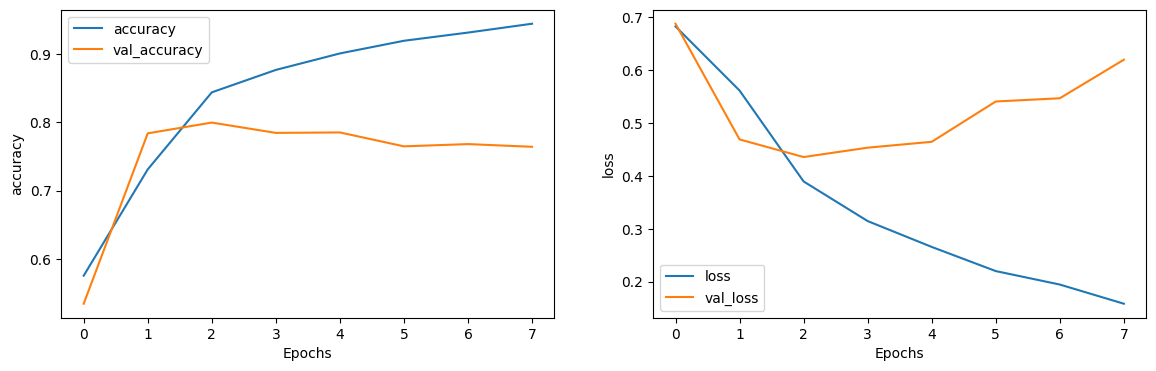

In [24]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    
    
plt.figure(figsize=(14,4))
plt.subplot(121)
plot_graphs(history, "accuracy")
plt.subplot(122)
plot_graphs(history, "loss")


# Text classification with RNN

In [26]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)

    model = tf.keras.Sequential()
    model.add(vectorize_layer)
    model.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer= tf.keras.optimizers.Adam(amsgrad=True, learning_rate=0.001),                 
                  metrics=['accuracy']) 
    
    model.summary()

    return model

In [27]:
print(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

10000 64 120


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 120)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 120, 64)           640000    
                                                                 
 dropout_3 (Dropout)         (None, 120, 64)           0         
                                                                 
 bidirectional (Bidirection  (None, 120, 32)           10368     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                2624      
 onal)                                                           
                                                      

In [28]:
history = model.fit(train_sentences, train_labels.astype(int), 
                    epochs=20, 
                    callbacks = callbacks_list,
                    validation_data=(val_sentences, val_labels.astype(int)))

Epoch 1/20
191/191 [==============================] - 27s 117ms/step - loss: 0.5714 - accuracy: 0.7043 - val_loss: 0.4698 - val_accuracy: 0.7840
Epoch 2/20
191/191 [==============================] - 24s 125ms/step - loss: 0.3668 - accuracy: 0.8585 - val_loss: 0.4965 - val_accuracy: 0.7794
Epoch 3/20
191/191 [==============================] - 21s 108ms/step - loss: 0.2686 - accuracy: 0.9080 - val_loss: 0.5212 - val_accuracy: 0.7669
Epoch 4/20
191/191 [==============================] - 17s 90ms/step - loss: 0.2008 - accuracy: 0.9325 - val_loss: 0.6261 - val_accuracy: 0.7492
Epoch 5/20
191/191 [==============================] - 16s 85ms/step - loss: 0.1462 - accuracy: 0.9529 - val_loss: 0.6949 - val_accuracy: 0.7367
Epoch 6/20
191/191 [==============================] - 18s 93ms/step - loss: 0.1129 - accuracy: 0.9589 - val_loss: 0.9709 - val_accuracy: 0.7242


In [29]:
model.evaluate(val_sentences, val_labels.astype(int))

48/48 [==============================] - 1s 21ms/step - loss: 0.4698 - accuracy: 0.7840


[0.4697977304458618, 0.7839789986610413]

# Conclusion

From the above code, we can see that the model is able to perform quite well even on a low trainin epoch. Though, the model is likely overfitting and we could reduce the epochs from 5 to something lower to generalize a bit better.

We can also see that the model using the recurrent structure is able to perform better than models that are not using this structure. This displays the importance of the notion of memory in the LSTM architecture!